In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the input image from the uploaded file
input_image = cv2.imread('Lena.jpg', 0)

# Check if the image is loaded correctly
if input_image is None:
    raise FileNotFoundError("The image file was not found or could not be read.")

M, N = input_image.shape

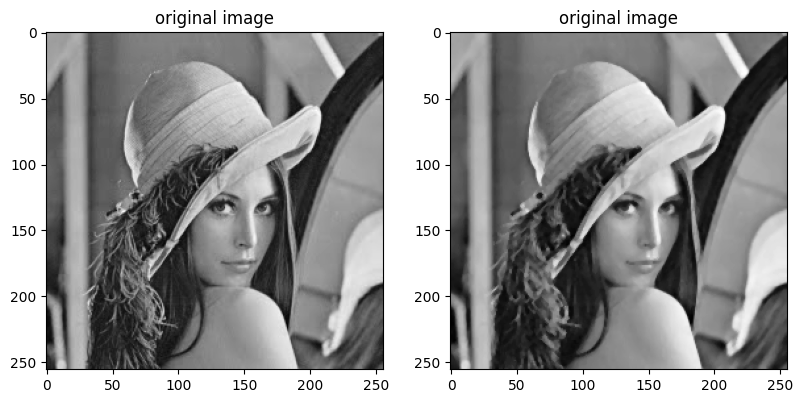

In [18]:
def median_predictor(image,M,N):

    predicted_image = np.zeros((M, N), dtype=np.uint8)
    error_map = np.zeros((M, N), dtype=np.uint8)

    # Pad the image with zeros to handle edge cases
    padded_image = np.pad(image, 1, mode='constant')

    # Extract the neighboring pixels
    x_ij = padded_image[1:-1, 1:-1]
    x_i_1_j = padded_image[:-2, 1:-1]
    x_i_j_1 = padded_image[1:-1, :-2]
    x_i_1_j_1 = padded_image[:-2, :-2]

    # Compute the predicted values using vectorized operations
    cond1 = x_i_1_j_1 <= np.minimum(x_i_1_j, x_i_j_1)
    cond2 = x_i_1_j_1 >= np.maximum(x_i_1_j, x_i_j_1)
    predicted_x_ij = np.where(cond1, np.minimum(x_i_1_j, x_i_j_1),
                              np.where(cond2, np.maximum(x_i_1_j, x_i_j_1),
                                       x_i_j_1 + x_i_1_j - x_i_1_j_1))

    # Compute the error map using vectorized operations
    e_ij = x_ij - predicted_x_ij
    t_ij = (np.abs(e_ij) > 127).astype(np.uint8)

    # Assign the results to the output arrays
    predicted_image = predicted_x_ij
    error_map = t_ij

    return predicted_image, error_map

# image_median_prediction, image_error_map = median_predictor(input_image,M,N)

image_median_prediction = cv2.medianBlur(input_image,3)

plt.figure(figsize=(20, 10))

plt.subplot(2,4,1)
plt.imshow(input_image,cmap="gray")
plt.title('original image')
plt.subplot(2,4,2)
plt.imshow(image_median_prediction,cmap="gray")
plt.title('original image')

plt.show()

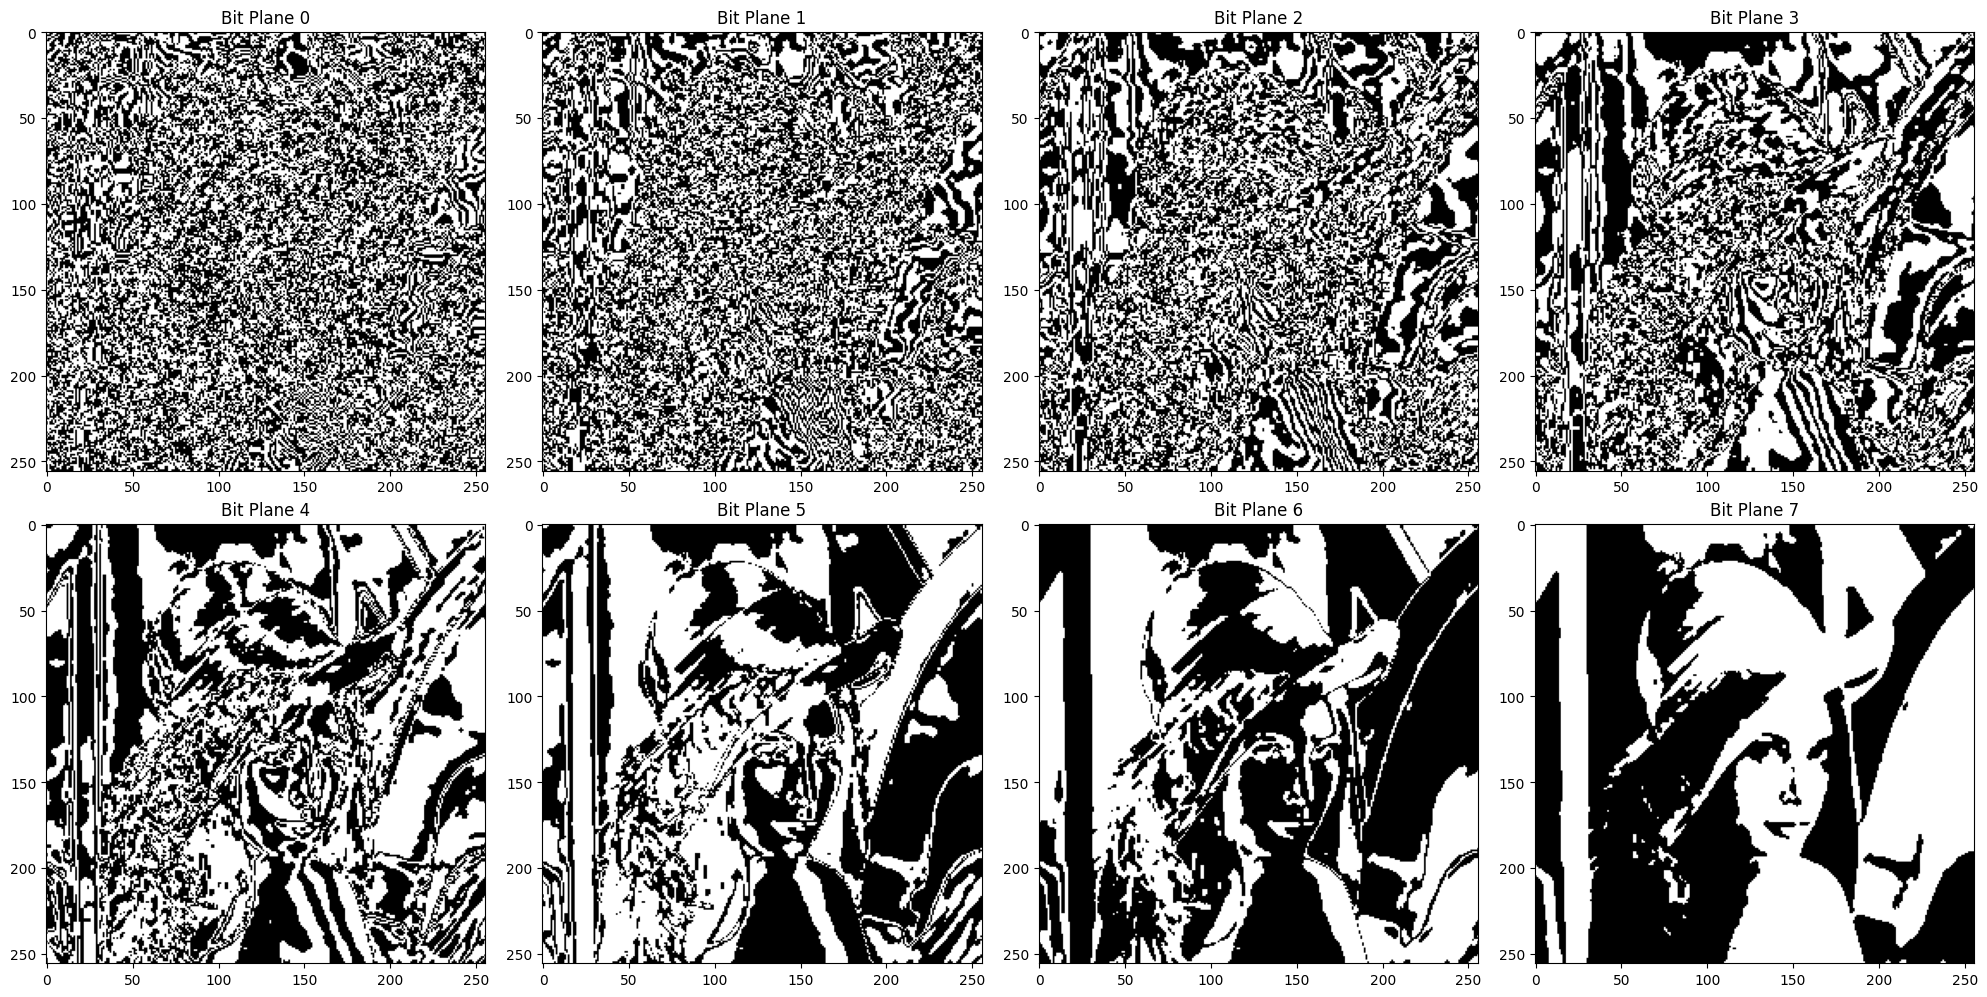

In [19]:
def bit_plane_slicing(image):
    planes = []
    for i in range(8):
        plane = (image >> i) & 1
        planes.append(plane)
    return np.array(planes, dtype=np.uint8)

bit_planes = bit_plane_slicing(image_median_prediction)

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(2, 4, i+1)  # Change 1,2 to 2,4 and i to i+1
    plt.imshow(bit_planes[i], cmap="gray")
    plt.title(f'Bit Plane {i}')  # Use f-string to format the title

plt.tight_layout()  # Add this to ensure subplots fit nicely
plt.show()

In [20]:
def image_encryption(xor_planes, key, M, N):
    new_planes = []
    for a in range(8):
        plane = xor_planes[a] ^ key[a]
        new_planes.append(plane)
    return np.array(new_planes, dtype=np.uint8)

image_key = np.random.randint(0, 2, size=(8, M, N), dtype=np.uint8)
encrypt_image = image_encryption(bit_planes, image_key, M, N)

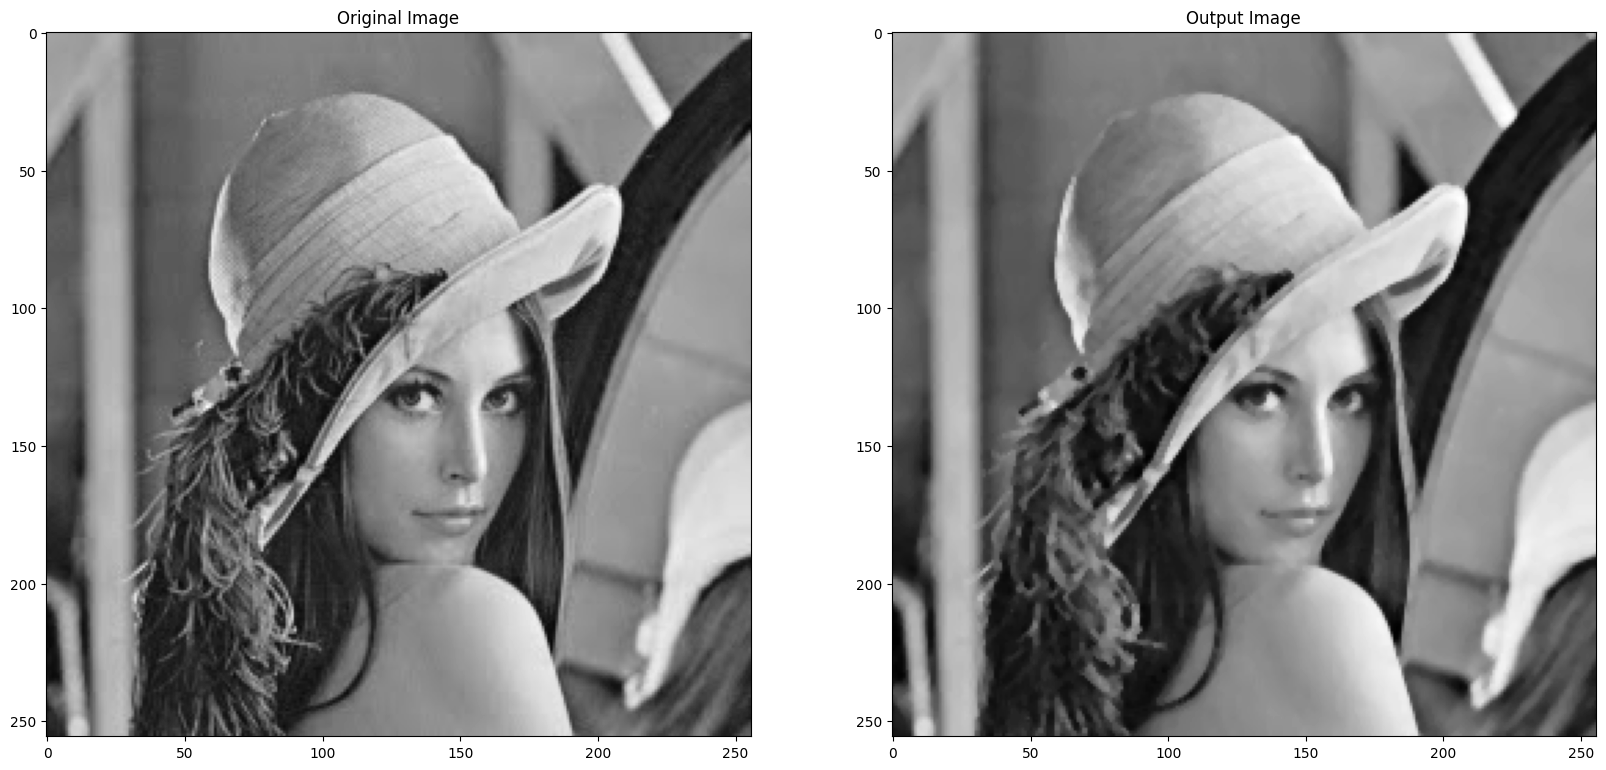

Extracted Text:  Hello buddy, this side gaurav sonkar


In [21]:
def lsb_vacant(image):
    encrypted_image_plane_zero = image[0]
    return np.array(encrypted_image_plane_zero, dtype=np.uint8)

def text_to_matrix(text, m, n):
    plane = np.zeros((m * n), dtype=int)
    ascii_values = [ord(c) for c in text]
    for i in range(len(ascii_values)):
        plane[i] = ascii_values[i]
    return np.array(plane.reshape(m, n), dtype=np.uint8)

def lsb_data_embedding(encrypt_plane, data):
    data_key = np.random.randint(0, 2, size=(M, N), dtype=np.uint8)
    encrypted_data = data ^ data_key
    encrypt_plane[0] = encrypted_data
    return np.array(encrypt_plane, dtype=np.uint8), np.array(data_key, dtype=np.uint8)

encrypted_image_plane_zero = lsb_vacant(encrypt_image)

text = "Hello buddy, this side gaurav sonkar"
secret_data = text_to_matrix(text, M, N)

embed_data_image, data_key = lsb_data_embedding(encrypt_image, secret_data)

# Step 5: Data extraction
def data_extract(data_embedding, key):
    return np.array(data_embedding[0] ^ key, dtype=np.uint8)

def matrix_to_text(matrix):
    flat_array = matrix.flatten()
    chars = [chr(val) for val in flat_array if val != 0]  # avoid null characters
    text = ''.join(chars)
    return text

matrix = data_extract(embed_data_image, data_key)
extracted_text = matrix_to_text(matrix)

# Step 6: Image recovery
def image_recovery(image, plane_zero):
    m, n = plane_zero.shape
    image[0] = np.zeros((m, n), dtype=np.uint8)
    image[0] = plane_zero
    return np.array(image, dtype=np.uint8)

recover_image = image_recovery(embed_data_image, encrypted_image_plane_zero)

# Step 7: Decrypt image
def decryption(bit_planes, key):
    new_planes = []
    for a in range(8):
        plane = bit_planes[a] ^ key[a]
        new_planes.append(plane)
    return np.array(new_planes, dtype=np.uint8)

decrypt = decryption(recover_image, image_key)

# Step 8: Reassemble the image
def reassemble_image(planes):
    new_image = np.zeros_like(planes[0])
    for i in range(8):
        new_image += planes[i] * (1 << i)
    return np.array(new_image, dtype=np.uint8)

output_image = reassemble_image(decrypt)

# Plot the original and output images
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap="gray")
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap="gray")
plt.title('Output Image')

plt.show()

# Print the extracted text
print("Extracted Text: ", extracted_text)